In [1]:
require(flowCore)
require(MetaCyto)
require(tidyverse)
require(data.table)
require(ggplot2)
require(FlowSOM)
require(viridis)
require(uwot)
library(patchwork)
require(reshape2)
library(gridExtra)
library(parallel)


Loading required package: flowCore

Warning message:
“package ‘flowCore’ was built under R version 4.3.3”
Loading required package: MetaCyto

Error: package or namespace load failed for ‘MetaCyto’ in loadNamespace(j <- i[[1L]], c(lib.loc, .libPaths()), versionCheck = vI[[j]]):
 namespace ‘ggplot2’ 3.4.4 is already loaded, but >= 3.5.0 is required

Loading required package: tidyverse

Warning message:
“package ‘tidyverse’ was built under R version 4.3.3”
Warning message:
“package ‘tibble’ was built under R version 4.3.3”
Warning message:
“package ‘tidyr’ was built under R version 4.3.3”
Warning message:
“package ‘readr’ was built under R version 4.3.3”
Warning message:
“package ‘purrr’ was built under R version 4.3.3”
Warning message:
“package ‘dplyr’ was built under R version 4.3.3”
Warning message:
“package ‘stringr’ was built under R version 4.3.3”
Warning message:
“package ‘forcats’ was built under R version 4.3.3”
Warning message:
“package ‘lubridate’ was built under R version 4.3.

In [2]:
scaleData <- function(dt, fa, quant.lo = 0.001, quant.hi = 0.999) {
  print("Scaling data")
  channels <- setdiff(colnames(dt), fa)  # Columns to scale
  
  refs.lo <- sapply(channels, function(col) quantile(dt[[col]], probs = quant.lo, na.rm = TRUE))
  refs.hi <- sapply(channels, function(col) quantile(dt[[col]], probs = quant.hi, na.rm = TRUE))
  
  for (col in channels) {
    dt[, (col) := (get(col) - refs.lo[col]) / (refs.hi[col] - refs.lo[col])]
  }
  return(dt)
}

In [3]:
meta_data=read.csv('fcs_meta_data.csv')
rownames(meta_data)<-meta_data$filename

In [4]:
annotation <- data.frame(
  Conjugate = c("BUV395", "BUV496", "BUV805", "BV421", "FVS510-A", "BV711", "Spark Blue 550", "RB613", "RB780", "Alexa Fluor 647", "APC-Fire 750"),
  Target = c("CD3", "CD45RA", "CD27", "IL4", "FSV510", "CXCR5", "CD8","CD4", "CD40L", "IFNg", "CCR7"),
  Location = c("Surface", "Surface", "Surface", "IC", "Live_Dead", "Surface",  "Surface", "Surface", "Surface", "IC", "Surface"),
  stringsAsFactors = FALSE
)

In [5]:
annotation

Conjugate,Target,Location
<chr>,<chr>,<chr>
BUV395,CD3,Surface
BUV496,CD45RA,Surface
BUV805,CD27,Surface
BV421,IL4,IC
FVS510-A,FSV510,Live_Dead
BV711,CXCR5,Surface
Spark Blue 550,CD8,Surface
RB613,CD4,Surface
RB780,CD40L,Surface


In [6]:
files <- list.files(path="/home//workspace/IHA_Figure_Revision/Dataset/TCR_Stim_Flow/", pattern=".fcs", full.names=FALSE, recursive=FALSE)


In [57]:


df_exp_list<-mclapply(files, function(file) {
df <- read.FCS(paste0("FCS/", file), transformation = FALSE, emptyValue = FALSE, truncate_max_range = FALSE)
df_exp <- as.data.frame(df@exprs)

colnames(df_exp)<-gsub("-A","",colnames(df_exp))

colnames(df_exp) <- ifelse(colnames(df_exp) %in% annotation$Conjugate, 
                        annotation$Target[match(colnames(df_exp), annotation$Conjugate)], 
                        colnames(df_exp))
df_exp<-cbind(df_exp,meta_data[file,2:7])
return(df_exp)    
},mc.cores=25)

In [58]:
length(df_exp_list)

[1] 64

In [154]:
combined<-do.call(rbind,df_exp_list)

In [155]:
combined <- combined %>%
  group_by(expt) %>%
  mutate(across(1:18, ~ asinh(.x / 220))) %>%
  ungroup()  

In [156]:
com_list<-list()
for (exp in unique(combined$expt)){


combined_subset<-combined %>% filter(expt==exp)
combined_subset[1:18]<-scaleData(combined_subset[1:18],fa=colnames(combined_subset[1:18]))
com_list[[exp]] <-  combined_subset
}

combined<-do.call(rbind,com_list)

[1] "Scaling data"
[1] "Scaling data"
[1] "Scaling data"


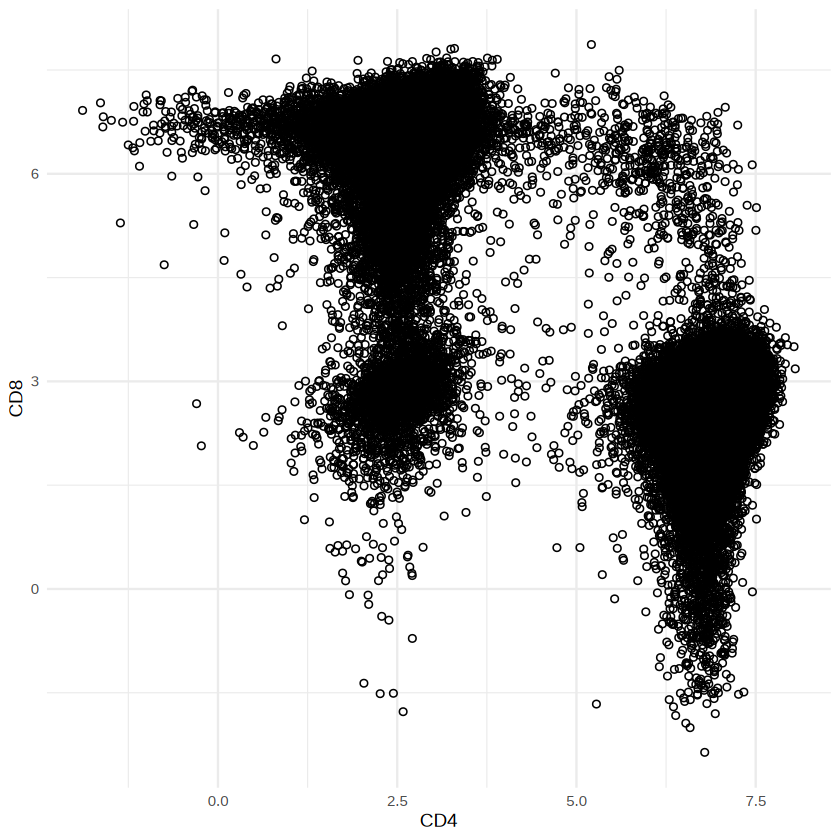

In [157]:
ggplot(combined[sample(nrow(combined), 100000), ], aes(x = `CD4`, y = `CD8`)) +
    geom_point(color = "black", pch = 21) +
    theme(legend.position = "right") +
    theme_minimal()

In [158]:
combined_live<-combined 

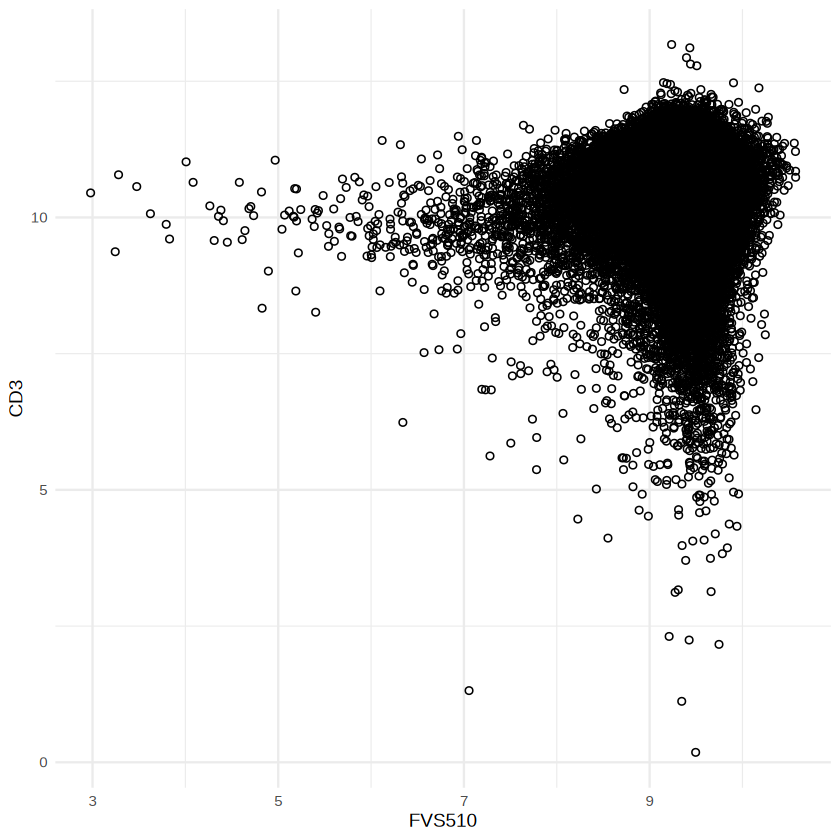

In [86]:
ggplot(combined_live[sample(nrow(combined_live), 100000), ], aes(x = `FVS510`, y = `CD3`)) +
    geom_point(color = "black", pch = 21) +
    theme(legend.position = "right") +
    theme_minimal()

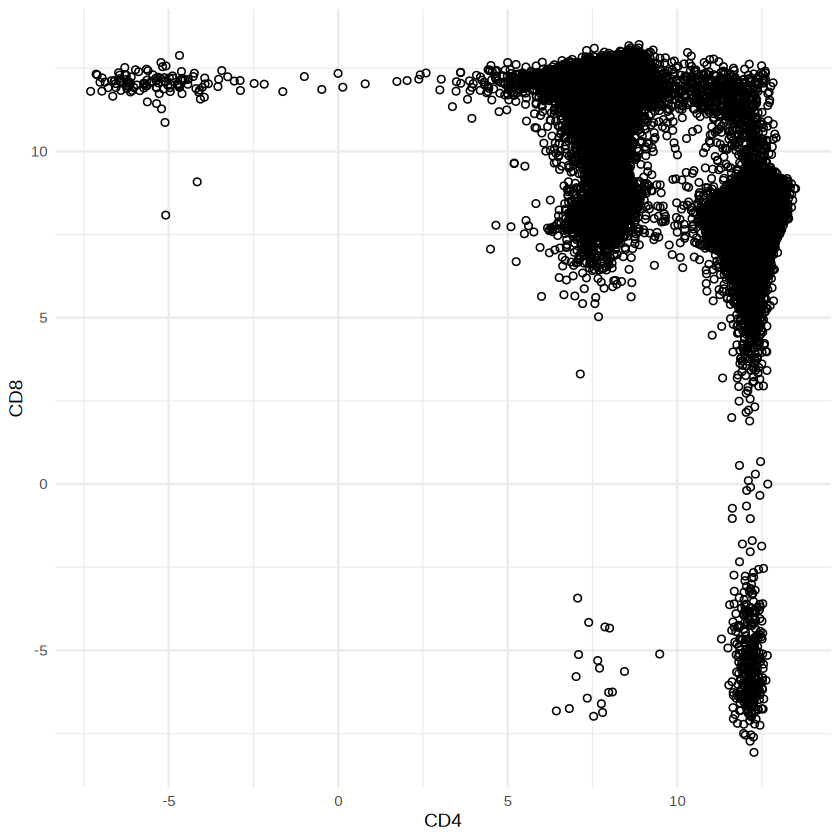

In [87]:
ggplot(combined_live[sample(nrow(combined_live), 100000), ], aes(x = `CD4`, y = `CD8`)) +
    geom_point(color = "black", pch = 21) +
    theme(legend.position = "right") +
    theme_minimal()

In [159]:
arrow::write_parquet(combined_live,"filtered.parquet")